# `scatter` plot

This notebook is designed to demonstrate (and so document) how to use the `shap.plots.scatter` function. It uses an XGBoost model trained on the classic UCI adult income dataset (which is a classification task to predict if people made over \\$50k in the 90s).

In [1]:
import xgboost

import shap

# train XGBoost model
X, y = shap.datasets.adult()
model = xgboost.XGBClassifier().fit(X, y)

# compute SHAP values
explainer = shap.Explainer(model, X)
explanation = explainer(X[:1000])

## Simple dependence scatter plot

A dependence scatter plot shows the effect a single feature has on the predictions made by the model. In this example probability of making over 50k increases significantly between age 20 and 40.

- Each dot is a single prediction (row) from the dataset.
- The x-axis is the value of the feature (from the X matrix, stored in `explanation.data`).
- The y-axis is the SHAP value for that feature (stored in `explanation.values`), which represents how much knowing that feature's value changes the output of the model for that sample's prediction. For this model the units are log-odds of making over 50k annually.
- The light grey area at the bottom of the plot is a histogram showing the distribution of data values.

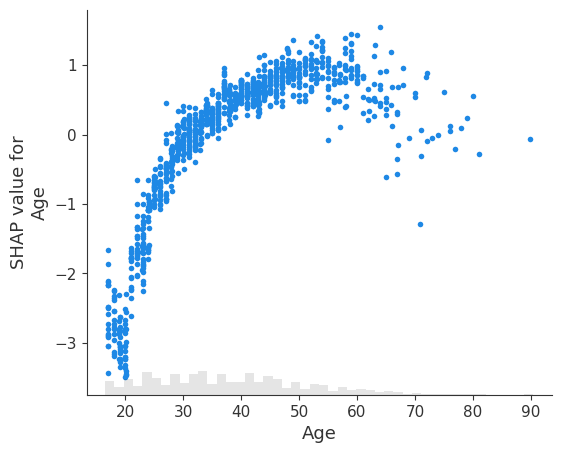

In [2]:
# Note that we are slicing off the column of the shap_values Explanation corresponding to the "Age" feature
shap.plots.scatter(explanation[:, "Age"])

## Using color to highlight interaction effects

The vertical dispersion in the plot above shows that the same value for the Age feature can have a different impact on the model's output for different people. This means there are non-linear interaction effects in the model between Age and other features (otherwise the scatter plot would perfectly follow the line given by `shap.plots.partial_dependence`).

To show which feature may be driving these interaction effects we can color our Age dependence scatter plot by another feature. If we pass the entire Explanation object to the color parameter then the scatter plot attempts to pick out the feature column with the strongest interaction with Age. If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring. For the example below, 20-year-olds with a high level of education are less likely make over \\$50k than 20-year-olds with a low level of education. This suggests an interaction effect between Education-Num and Age.

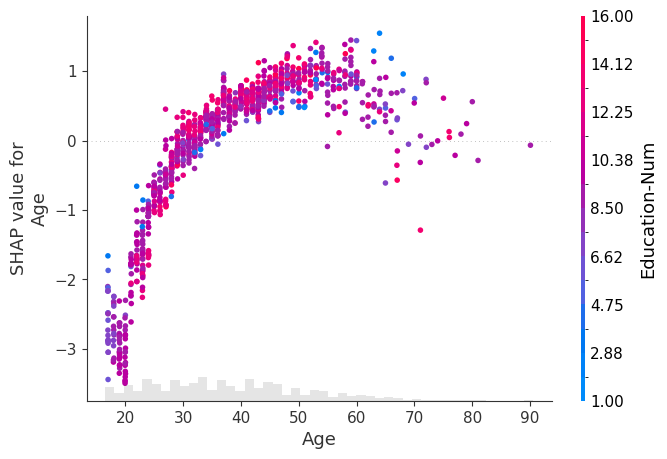

In [3]:
shap.plots.scatter(explanation[:, "Age"], color=explanation)

To explicitly control which feature is used for coloring you can pass a specific feature column to the `color` parameter.

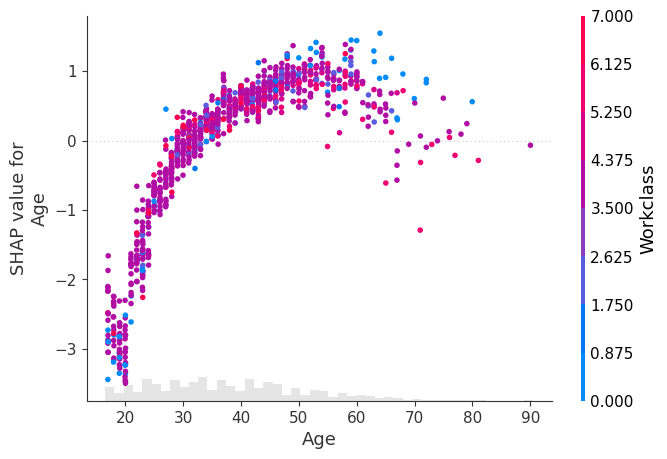

In [4]:
shap.plots.scatter(explanation[:, "Age"], color=explanation[:, "Workclass"])

In the plot above we see that the Workclass feature is encoded with a number for the sake of the XGBoost model. When plotting though we often would rather use the original string values before they were categorically encoded. To do this we can set the `.display_data` property of the Explanation object to a parallel version of the data we would like displayed in plots.

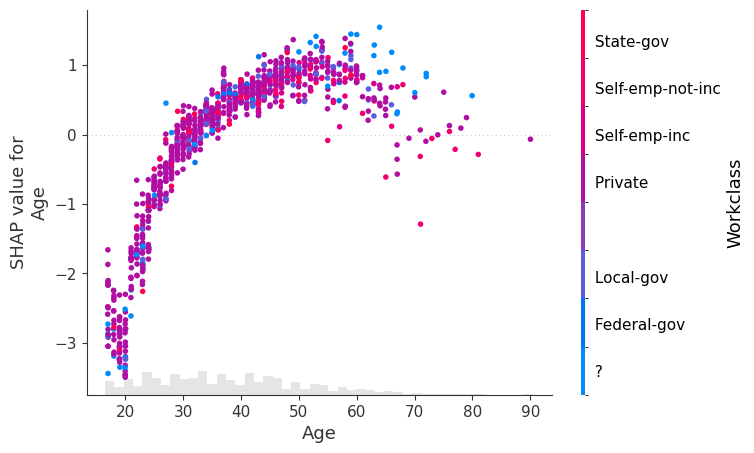

In [5]:
X_display, y = shap.datasets.adult(display=True)
explanation.display_data = X_display.values

shap.plots.scatter(explanation[:, "Age"], color=explanation[:, "Workclass"])

## Using global feature importance orderings

Sometimes we don't know the name or index of the feature we want to plot, we just want to plot the most important features. To do that we can use the dot-chaining capability of the Explanation object to compute a measure of global feature importance, sort by that measure (descending), and then pick out the top feature (which in this case is `Age`):

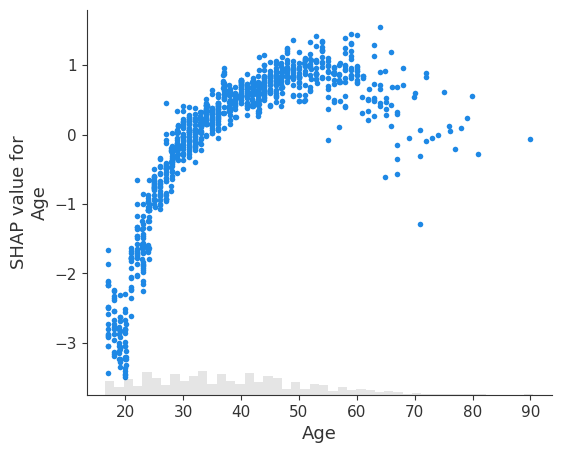

In [6]:
shap.plots.scatter(explanation[:, explanation.abs.mean(0).argsort[-1]])

And the second top feature, which is `Relationship`:

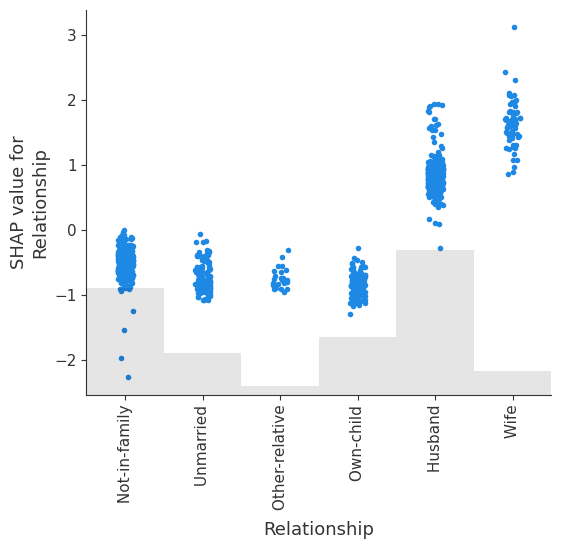

In [7]:
shap.plots.scatter(explanation[:, explanation.abs.mean(0).argsort[-2]])

We can explicitly observe the distribution of the shap values for different classes in `Relationship`. 

Note that how we chose to measure the global importance of a feature will impact the ranking we get. In this example `Age` is the feature with the largest mean absolute value of the whole dataset, but Capital gain is the feature with the largest absolute impact for any sample.

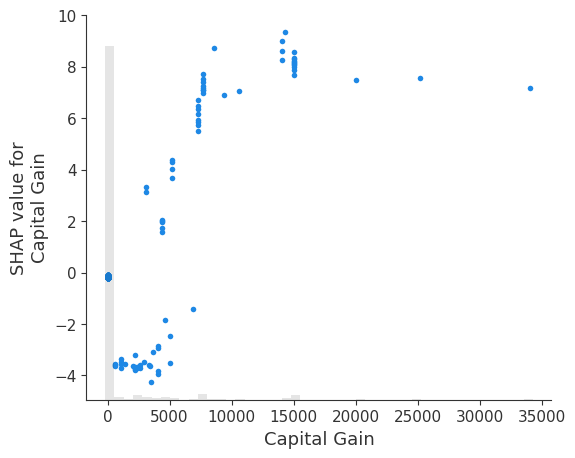

In [8]:
shap.plots.scatter(explanation[:, explanation.abs.max(0).argsort[-1]])

The max function is potentially sensitive to outliers. A more robust option would be to use the percentile function. Here we sort the features by their 95th percentile absolute value and find the Capital gain has the largest 95th percentile value:

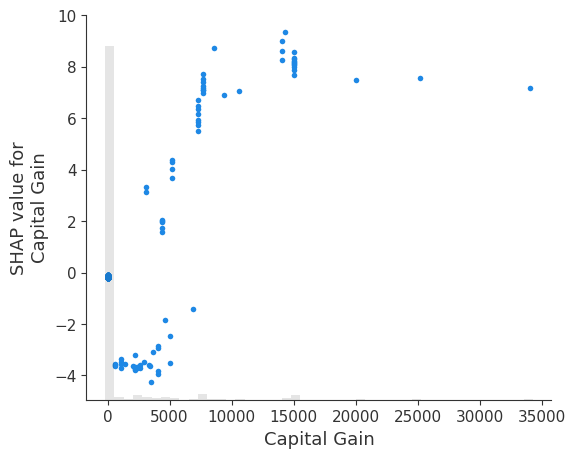

In [9]:
shap.plots.scatter(explanation[:, explanation.abs.percentile(95, 0).argsort[-1]])

## Exploring different interaction colorings

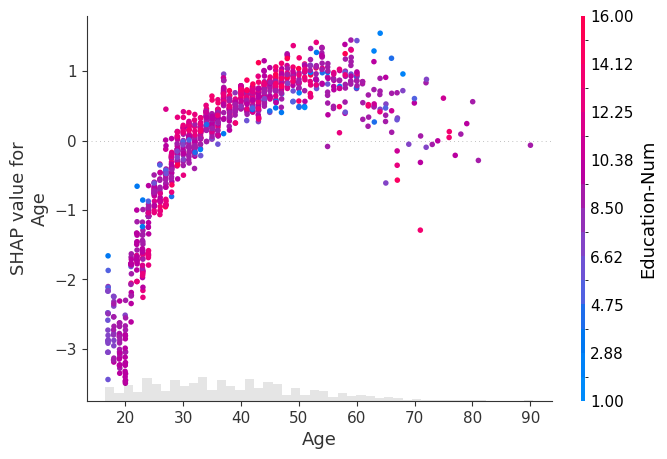

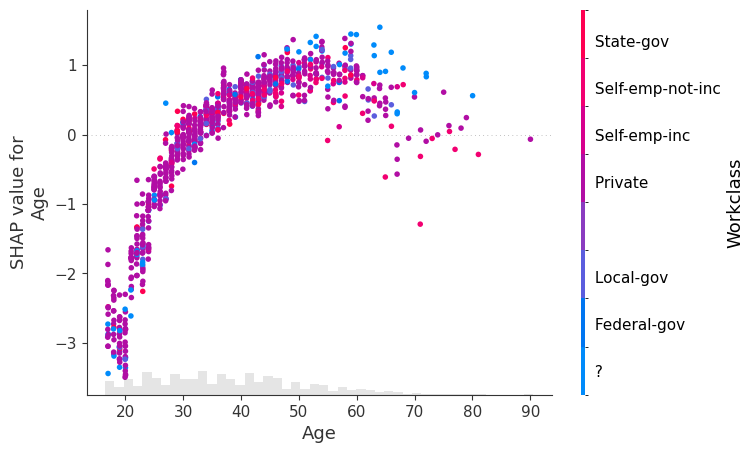

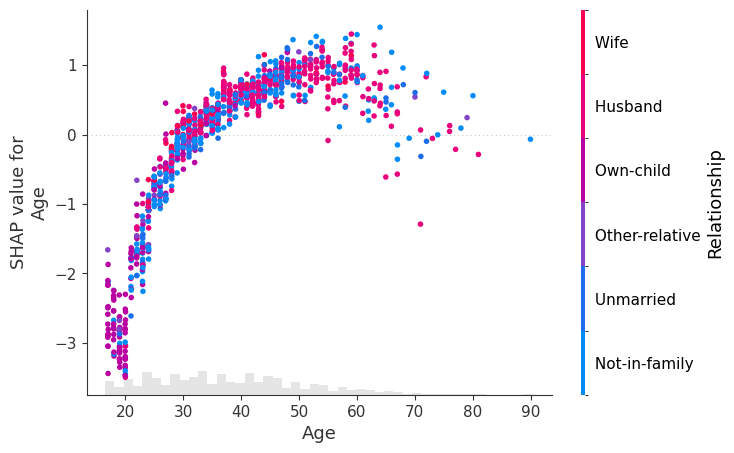

In [10]:
# we can use shap.approximate_interactions to guess which features
# may interact with age
inds = shap.utils.potential_interactions(explanation[:, "Age"], explanation)

# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.plots.scatter(explanation[:, "Age"], color=explanation[:, inds[i]])

## Customizing the figure properties

### Change title and tick label

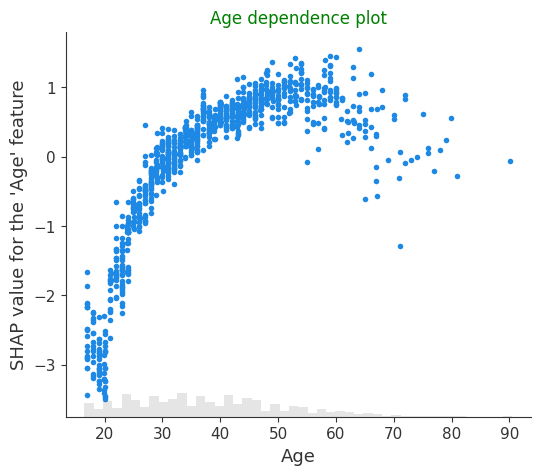

In [11]:
# by passing show=False you can prevent shap.dependence_plot from calling
# the matplotlib show() function, and so you can keep customizing the plot
# before eventually calling show yourself
import matplotlib.pyplot as plt

scatter = shap.plots.scatter(explanation[:, "Age"], show=False)
plt.title("Age dependence plot", color="g")
plt.ylabel("SHAP value for the 'Age' feature")

# plt.savefig("my_dependence_plot.pdf") # we can save a PDF of the figure if we want
plt.show()

### Control outliers 

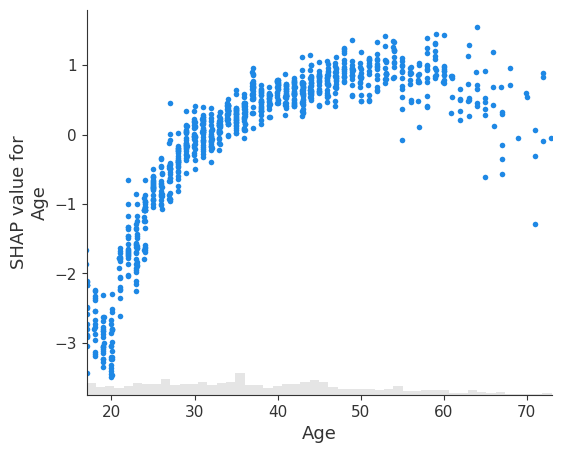

In [12]:
# you can use xmax and xmin with a percentile notation to hide outliers.
# note that the .percentile method applies to both the .values and .data properties
# of the Explanation object, and the scatter plots knows to use the .data propoerty
# when passed to the xmin or xmax arguments.
age = explanation[:, "Age"]
shap.plots.scatter(age, xmin=age.percentile(1), xmax=age.percentile(99))

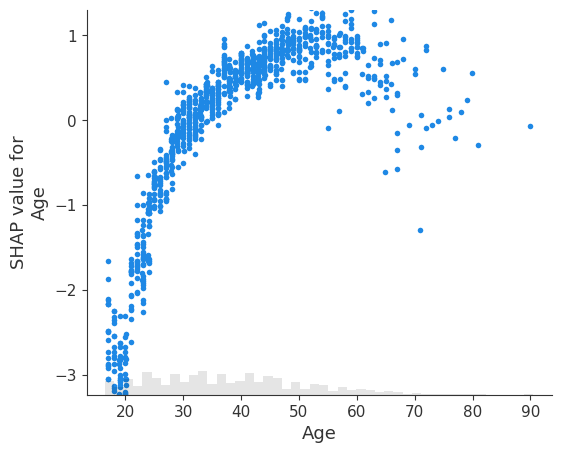

In [13]:
# you can use ymax and ymin with a percentile notation to hide vertical outliers.
# note that now the scatter plot uses the .value property for ymin and ymax if
# an explanation object is passed in those parameters.
age = explanation[:, "Age"]
shap.plots.scatter(age, ymin=age.percentile(1), ymax=age.percentile(99))

### Opacity of the points

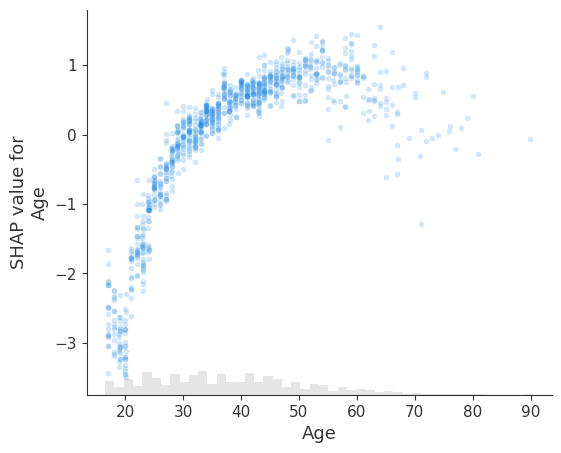

In [14]:
# transparency can help reveal dense vs. sparse areas of the scatter plot
shap.plots.scatter(explanation[:, "Age"], alpha=0.2)

### Change point size

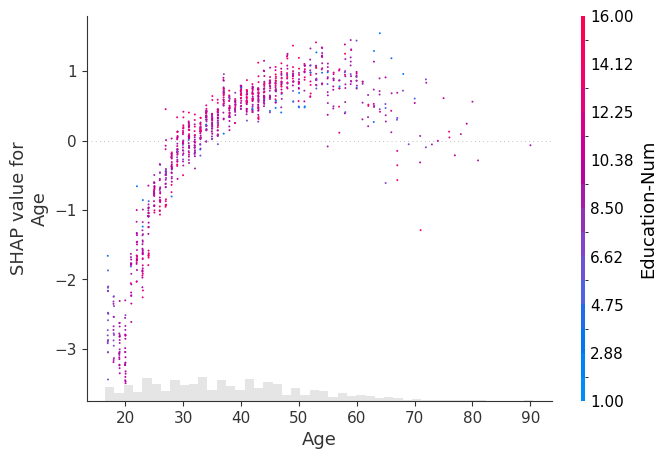

In [15]:
# transparency can help reveal dense vs. sparse areas of the scatter plot
shap.plots.scatter(explanation[:, "Age"], dot_size=2, color=explanation)  # default dot_size is 16

### Add x-jitter to points

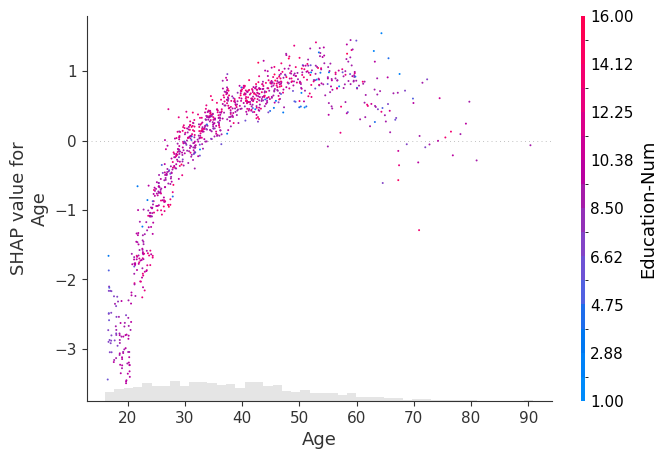

In [16]:
# for categorical (or binned) data adding a small amount of x-jitter makes
# thin columns of dots more readable
shap.plots.scatter(explanation[:, "Age"], dot_size=2, x_jitter=1, color=explanation)

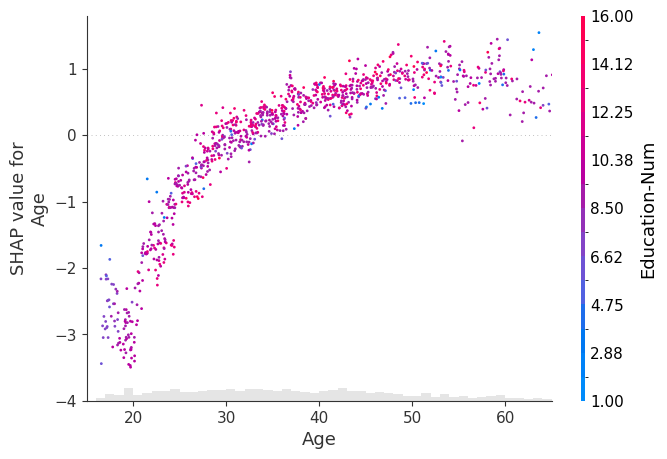

In [17]:
shap.plots.scatter(
    explanation[:, "Age"],
    dot_size=4,
    x_jitter=1,
    color=explanation,
    xmin=15,
    xmax=65,
    ymin=-4,
    ymax=1.8,
)

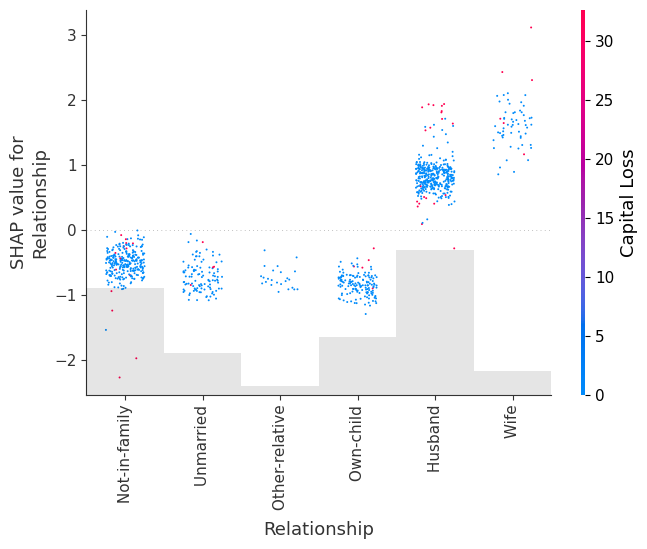

In [18]:
# for categorical (or binned) data adding a small amount of x-jitter makes
# thin columns of dots more readable
shap.plots.scatter(explanation[:, "Relationship"], dot_size=2, x_jitter=0.5, color=explanation)

### Custom colormap

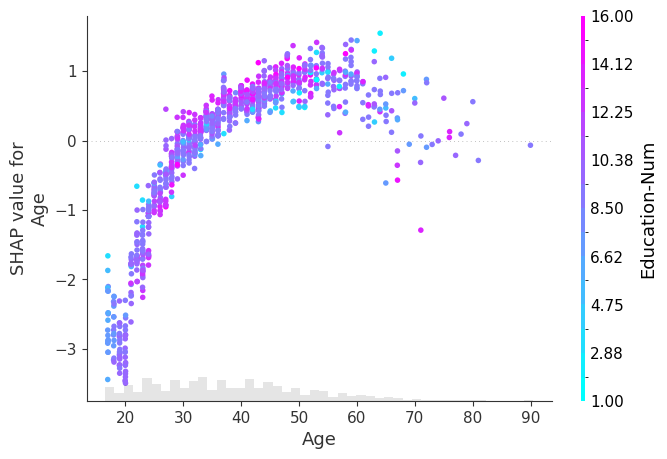

In [19]:
import matplotlib.pyplot as plt

# you can use the cmap parameter to provide your own custom color map
shap.plots.scatter(explanation[:, "Age"], color=explanation, cmap=plt.get_cmap("cool"))

### Other customizations

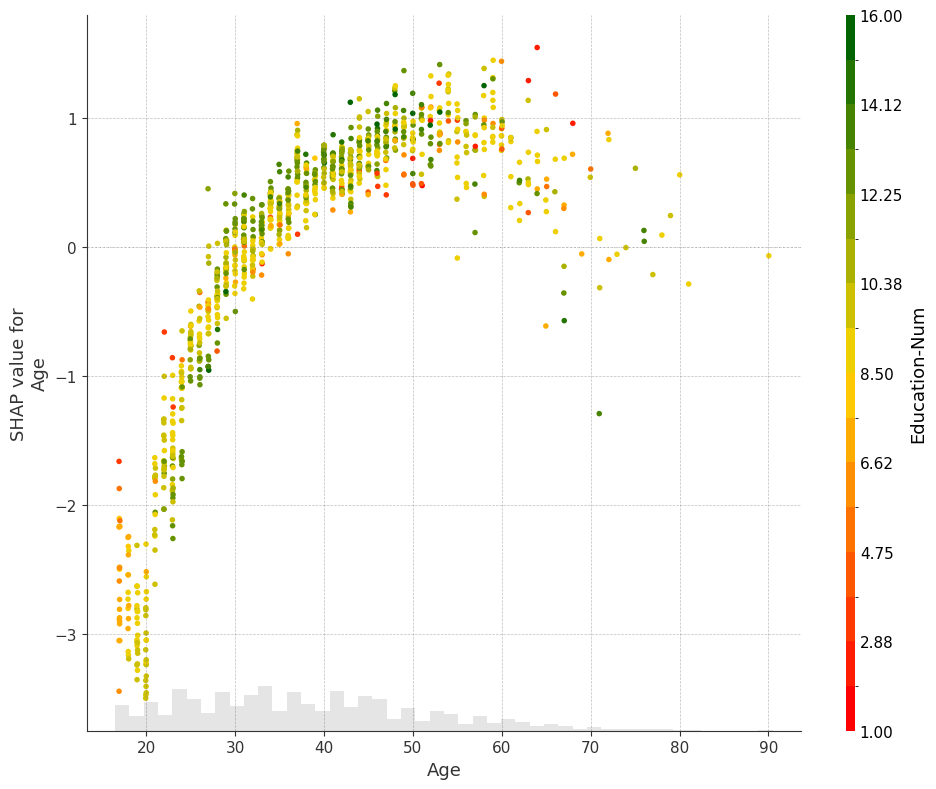

In [20]:
fig, ax = plt.subplots(tight_layout=True, figsize=(10, 8))

from matplotlib.colors import LinearSegmentedColormap

start_color = (1, 0, 0)  # red
middle_color = (1, 0.843, 0)  # gold
end_color = (0, 0.392, 0)

cmap = LinearSegmentedColormap.from_list("custom_cmap", [start_color, middle_color, end_color], N=1000)

ax.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.5)

shap.plots.scatter(explanation[:, "Age"], color=explanation, cmap=cmap, ax=ax)

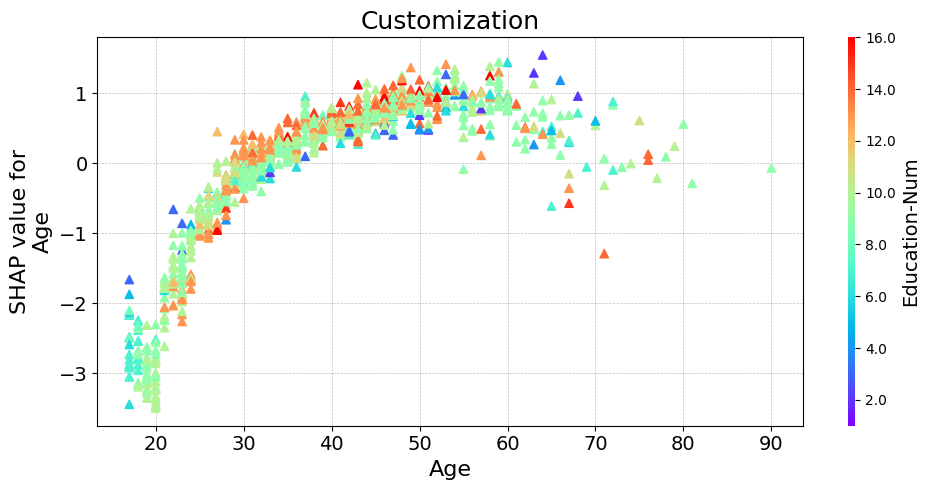

In [21]:
fig, ax = plt.subplots(tight_layout=True, figsize=(10, 5))

# or you need more flexible customization
scatter = ax.scatter(
    explanation[:, "Age"].data,
    explanation[:, "Age"].values,
    c=explanation[:, "Education-Num"].data,
    marker="^",
    cmap=plt.get_cmap("rainbow"),
    rasterized=True,
    zorder=5,
)

cbar = plt.colorbar(scatter, aspect=50, format="%2.1f")
cbar.set_label("Education-Num", fontsize=14)
cbar.outline.set_visible(False)

ax.set_title("Customization", fontsize=18)
ax.set_xlabel("Age", fontsize=16)
ax.set_ylabel("SHAP value for\nAge", fontsize=16)

ax.tick_params(labelsize=14)

ax.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.5)

plt.show()

<hr>
Have an idea for more helpful examples? Pull requests that add to this documentation notebook are encouraged! 